In [1]:
from get_era5_data_for_station import CreateMatchingEra5FileForStationData
from time_and_date_context_overlay import TimeAndDateContextOverlay
from create_training_sets import TrainingsFilePair


Process .dat files to create .nc files for the station

In [4]:
station_name = "Marshall"
import os
# if in station_data_as_nc folder there is no file with the name of the station, create one
station_as_nc_path = f"{os.getcwd()}/station_data_as_nc/{station_name.lower()}.nc"
needs_to_convert_to_netcdf = not os.path.isfile(station_as_nc_path)
print(f"needs_to_convert_to_netcdf: {needs_to_convert_to_netcdf}")

needs_to_convert_to_netcdf: False


In [ ]:
if needs_to_convert_to_netcdf:
    
    from dat_to_nc import DatToNcConverter
    converter = DatToNcConverter(station_name.lower())
    converter.execute()
    import xarray as xr
    ds = xr.open_dataset(converter.target_directory + "/" + converter.name.lower() + ".nc")


/home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/marshall.nc has  59151  values


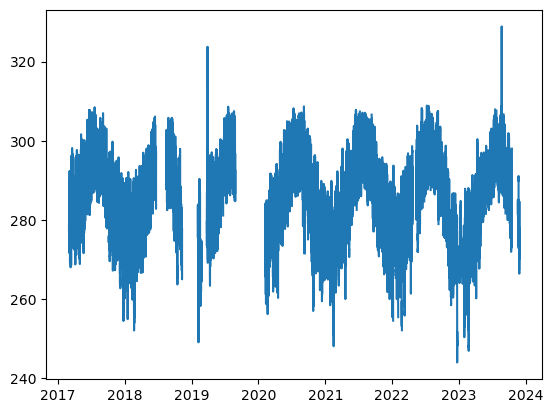

In [11]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(station_as_nc_path)

time_axis = ds.time.values
print(station_as_nc_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

# plot
plt.plot(time_axis, temperature_axis)
plt.show()

In [5]:
era5_getter = CreateMatchingEra5FileForStationData(station_name)
station_path = era5_getter.target_station_path
era5_path = era5_getter.target_era5_path
print(f"{station_name} coordinates: {era5_getter.station.get_lon_lat()}")
print(f"The data at {station_name} is inbetween {era5_getter.station.dataset.start_date} and {era5_getter.station.dataset.time_at_index(len(era5_getter.station.dataset.time)-1)}")
print("station cleared & processed file will be saved at: " + station_path)
print("era5 cleared & processed file will be saved at: " + era5_path)

Timezone for Marshall: America/Denver
UTC offset for Marshall: -7.0 hours
Marshall coordinates: (-105.196, 39.9496)
The data at Marshall is inbetween 2017-03-01 12:00:00 and 2023-11-30 02:00:00
station cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc
era5 cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall.nc


In [ ]:
problemantic_files = era5_getter.extract_areas_from_era5_datasets()

Test lon / lat value differences

In [ ]:
import netCDF4 as nc
import numpy as np
cropped_folder = era5_getter.target_temp_era5_folder
print(f"cropped_folder: {cropped_folder}")
last_lon = []
last_lat = []
for file in os.listdir(cropped_folder):
    ds = nc.Dataset(f"{cropped_folder}/{file.split('/')[-1]}")
    if len(last_lon):
        assert np.array_equal(last_lon, ds.variables['lon'][:]), f"{last_lon} != {ds.variables['lon'][:]} at {file}"
        assert np.array_equal(last_lat, ds.variables['lat'][:]), f"{last_lat} != {ds.variables['lat'][:]} at {file}"
    last_lon = ds.variables['lon'][:]
    last_lat = ds.variables['lat'][:]


In [ ]:
era5_getter.merge_era5_files()

In [ ]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(era5_getter.target_temp_era5_path)

plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(1)
plotter.plot()

In [4]:
processed_station_exported_at_path, \
processed_era5_for_station_exported_at_path \
    = era5_getter.transform_era5_to_match_station_time_dimension()

station data goes from 2017-03-01 12:00:00 to 2023-11-30 02:00:00
era5 data goes from 2017-03-01 12:00:00 to 2023-11-30 02:00:00
cropping time axis to intersection of station and era5 dataset
start/enddate (utc): 2017-03-01 12:00:00 / 2023-11-30 02:00:00


Checking tas: 100%|██████████| 59150/59150 [00:16<00:00, 3505.59it/s]


Found 12569 invalid values in station dataset
Found 0 invalid values in era5 dataset


100%|██████████| 12569/12569 [00:34<00:00, 366.95it/s]


Deleted 12569 timesteps from /home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/marshall.nc_temp dataset because of invalid values


100%|██████████| 12569/12569 [00:38<00:00, 330.35it/s]

Deleted 12569 timesteps from /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall.nc_temp dataset because of invalid values


/work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc has  46582  values


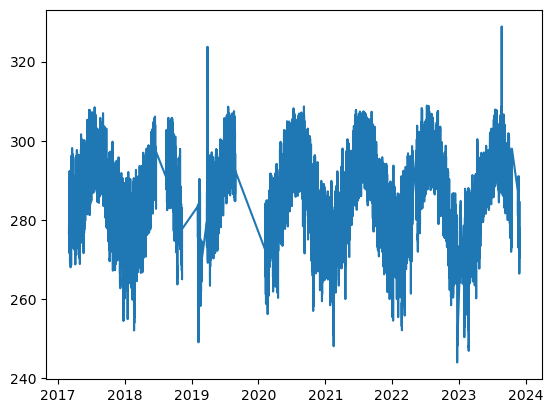

In [5]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(processed_station_exported_at_path)

time_axis = ds.time.values
print(processed_station_exported_at_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

# plot
plt.plot(time_axis, temperature_axis)
plt.show()

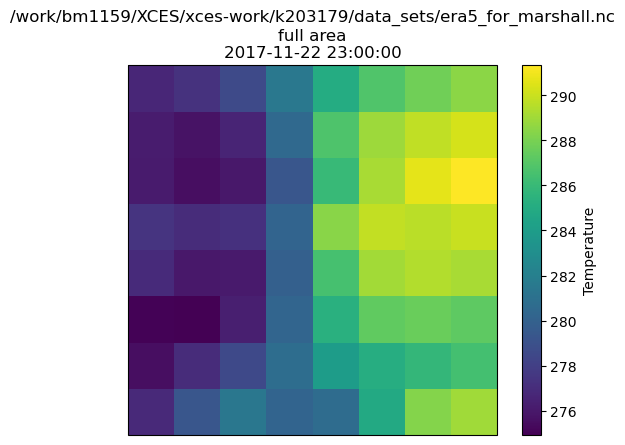

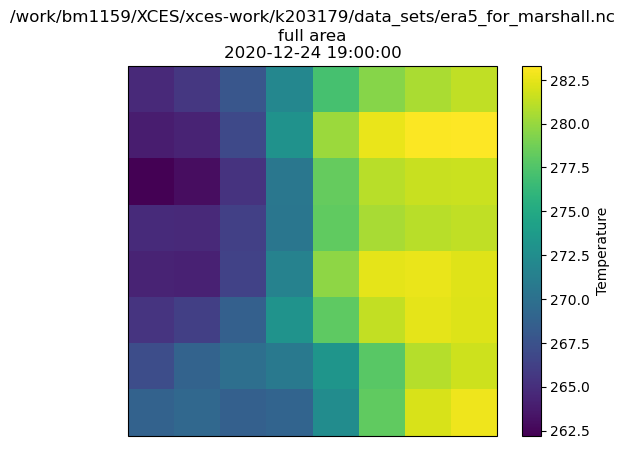

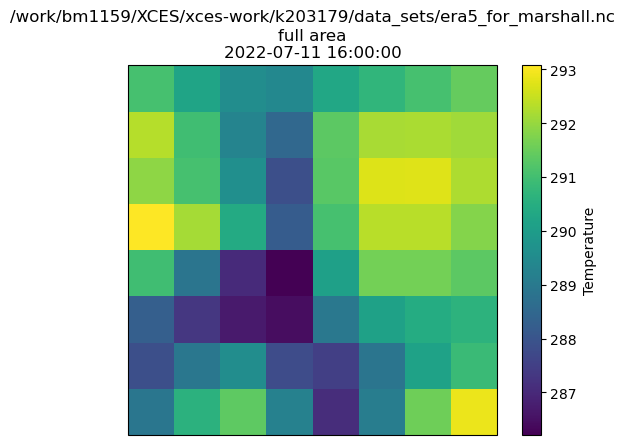

In [7]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(processed_era5_for_station_exported_at_path)

plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(3)
plotter.plot()

In [8]:
if plotter:
    plotter.dataset.dataset.close()

time_overlayer = TimeAndDateContextOverlay()
time_overlayer.apply_on_dataset(processed_era5_for_station_exported_at_path)

  0%|          | 0/46582 [00:00<?, ?it/s]


RuntimeError: NetCDF: HDF error

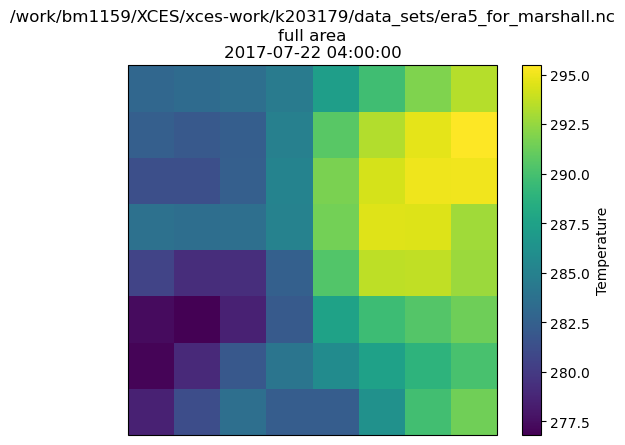

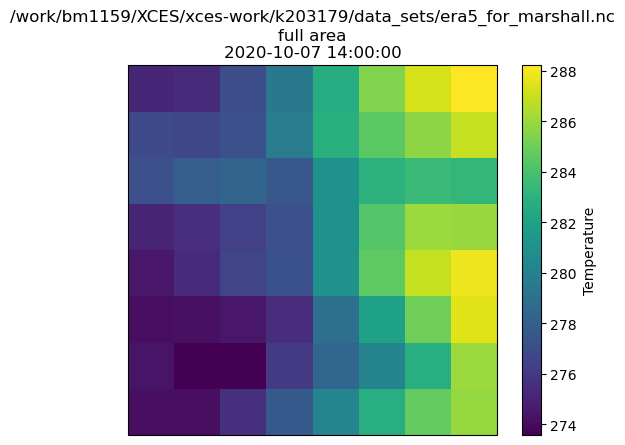

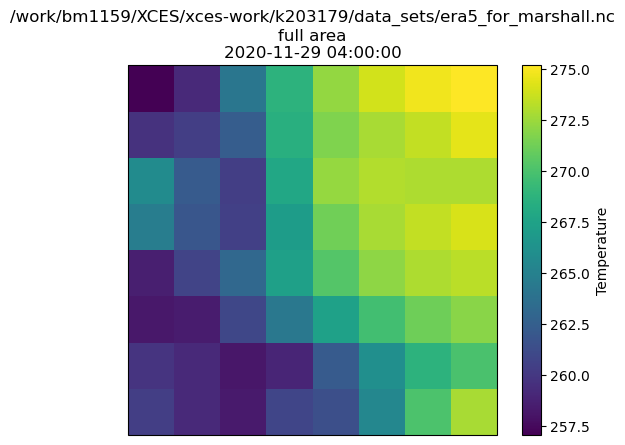

In [9]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(era5_path)

plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(3)
plotter.plot()

In [6]:
print(station_path, era5_path)
trainings_file_pair_creator = TrainingsFilePair(station_path, era5_path)
trainings_file_pair_creator.prepare_trainings_files()

/work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall.nc


KeyError: 'time'

In [ ]:
from utils import DataSet, DatasetPlotter
test_expected_set = DataSet(f"/work/bm1159/XCES/xces-work/k203179/data/train/era5_for_{station_name.lower()}.nc")
plotter = DatasetPlotter(test_expected_set)
plotter.generate_time_index_list(4)
plotter.vmin = 270
plotter.vmax = 300
plotter.plot()

In [ ]:
from utils import DataSet, DatasetPlotter
test_expected_set = DataSet(f"/work/bm1159/XCES/xces-work/k203179/data/test/reality_{station_name.lower()}.nc")
plotter = DatasetPlotter(test_expected_set)
plotter.generate_time_index_list(4)
plotter.vmin = 270
plotter.vmax = 300
plotter.plot()